In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%run ../../helper/preprocess.py
%run ../../helper/aggregate.py
%run ../../helper/utils.py
%run xy_plot.py

matplotlib.rcParams['pdf.fonttype'] = 42
sns.set(style="white", font_scale=1.8)
figsize = (24, 6)
figsize_large = (24, 12)
bbox_to_anchor = (0.5, -0.1)

In [37]:
metric_types = ['Image Similarity', 'Squared Centroid Distance', 'Text Similarity', 'Vendi', 'Style Loss']
encoders = ['ConvNeXt V2', 'ConvNeXt V2', 'CLIP', 'ConvNeXt V2', 'Vgg19']
modes = ['resize']
prompt_types = ['in', 'trigger', 'out']

metrics_to_include = get_metric_list(metric_types, encoders, modes,
                                     prompt_types, style_with_base_model=True)
display(metrics_to_include)

[('Image Similarity', 'ConvNeXt V2-resize', 'in'),
 ('Image Similarity', 'ConvNeXt V2-resize', 'trigger'),
 ('Image Similarity', 'ConvNeXt V2-resize', 'out'),
 ('Squared Centroid Distance', 'ConvNeXt V2-resize', 'in'),
 ('Squared Centroid Distance', 'ConvNeXt V2-resize', 'trigger'),
 ('Squared Centroid Distance', 'ConvNeXt V2-resize', 'out'),
 ('Text Similarity', 'CLIP', 'in'),
 ('Text Similarity', 'CLIP', 'trigger'),
 ('Text Similarity', 'CLIP', 'out'),
 ('Vendi', 'ConvNeXt V2', 'in'),
 ('Vendi', 'ConvNeXt V2', 'trigger'),
 ('Vendi', 'ConvNeXt V2', 'out'),
 ('Style Loss', 'Vgg19', 'in'),
 ('Style Loss', 'Vgg19', 'trigger'),
 ('Style Loss', 'Vgg19', 'out'),
 ('Style Loss', 'Vgg19', 'base model')]

In [38]:
metrics_file = '../../metrics/ddim_sd15_metrics.csv'
config_file = '../../../exp_configs/config_mapping.csv'

keywords_to_exclude = ['1007', '1017', '1027']

metrics_processed = load_and_preprocess_metrics(
    metrics_file,
    config_file,
    metrics_to_include=metrics_to_include,
    keywords_to_exclude=keywords_to_exclude)

In [39]:
metrics_to_plot = [(('Text Similarity', 'CLIP', 'out'),
                    ('Image Similarity', 'ConvNeXt V2-resize', 'out')),
                   (('Vendi', 'ConvNeXt V2', 'trigger'),
                    ('Squared Centroid Distance', 'ConvNeXt V2-resize',
                     'trigger')),
                   (('Style Loss', 'Vgg19', 'base model'),
                    ('Image Similarity', 'ConvNeXt V2-resize', 'in'))]

In [40]:
category = 'anime'

extra_conodition = {
    'Category': category,
}

save_dir = f'figures/appendix/{category}-convnextv2/'
os.makedirs(save_dir, exist_ok=True)

## Step

In [41]:
metrics_aggregated = filter_config_and_aggregate(metrics_processed, [],
                                                 extra_conodition)
shape_mapping = {
    10: 'epoch=10',
    30: 'epoch=30',
    50: 'epoch=50',
}

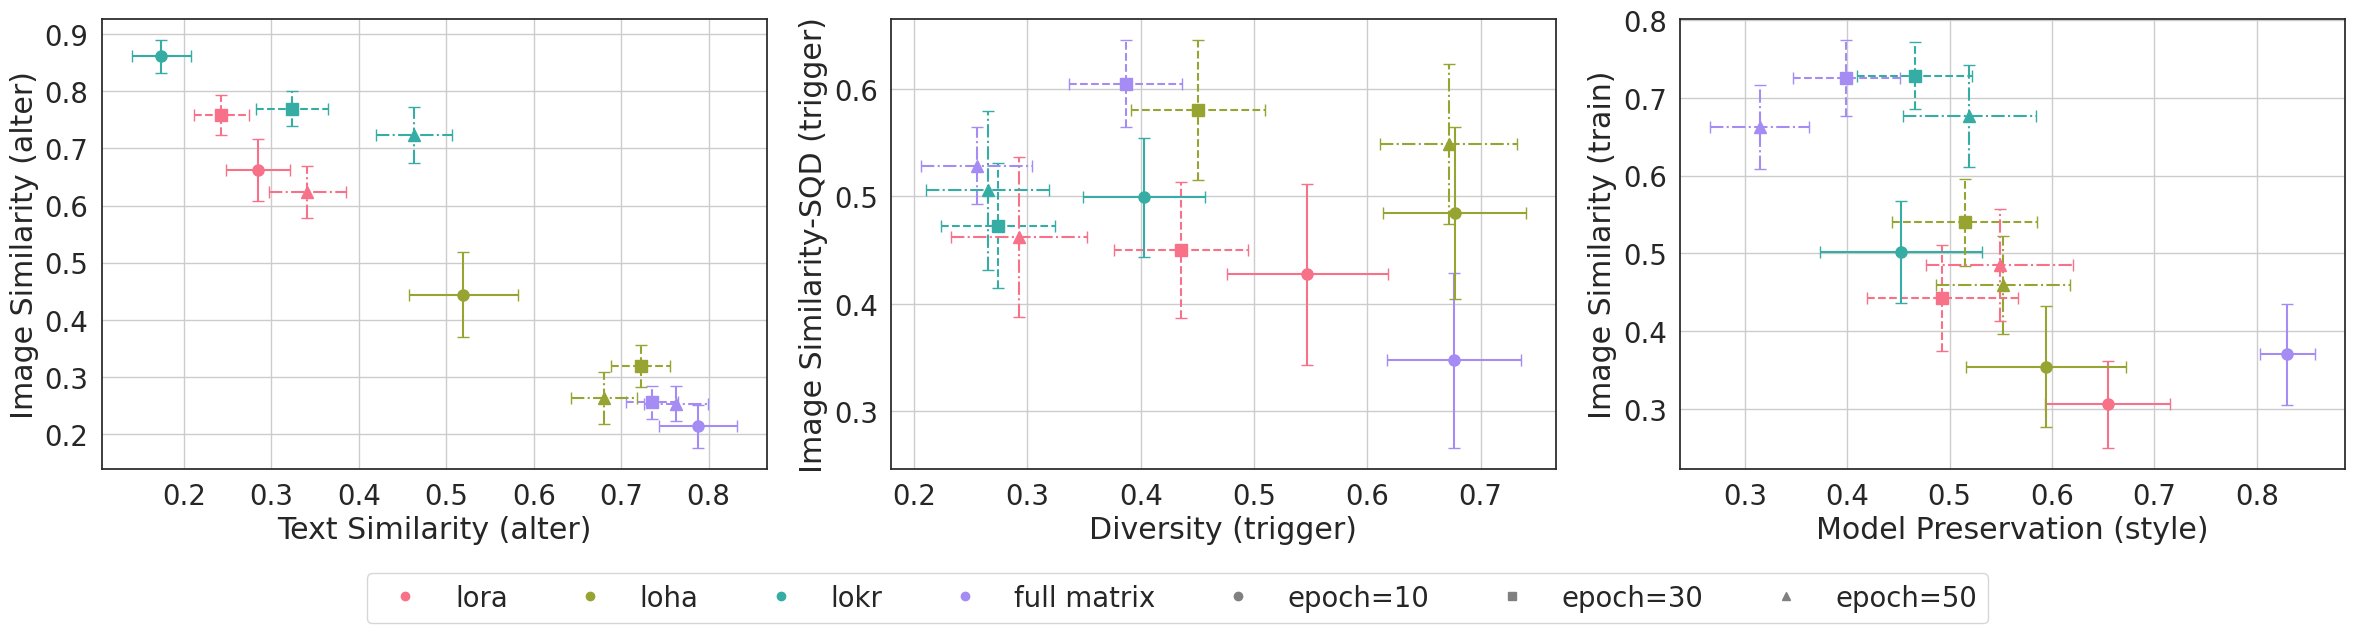

In [42]:
plt.figure(figsize=figsize)

for i, metric_pair in enumerate(metrics_to_plot):
    plt.subplot(1, 3, i + 1)
    legend_handles = plot_metrics_xy(metrics_aggregated,
                                     metric_pair[0],
                                     metric_pair[1],
                                     color_by='Algo',
                                     shape_by='Step',
                                     shape_mapping=shape_mapping,
                                     legend=False,
                                     step=None)
fig = plt.gcf()
# Get all axes in the current figure
# axes = fig.get_axes()
# # Turn off grid lines for each axis
# for ax in axes:
#     ax.grid(False)

fig.legend(handles=legend_handles,
           loc='lower center',
           bbox_to_anchor=bbox_to_anchor,
           ncol=len(legend_handles))
plt.tight_layout()

for ext in ['.png', '.pdf']:
    plt.savefig(os.path.join(save_dir, f'epoch_{category}_xyplot' + ext),
                bbox_inches='tight',
                pad_inches=0.2)

## Preset

In [43]:
metrics_aggregated = filter_config_and_aggregate(metrics_processed, ['Preset'],
                                                 extra_conodition)

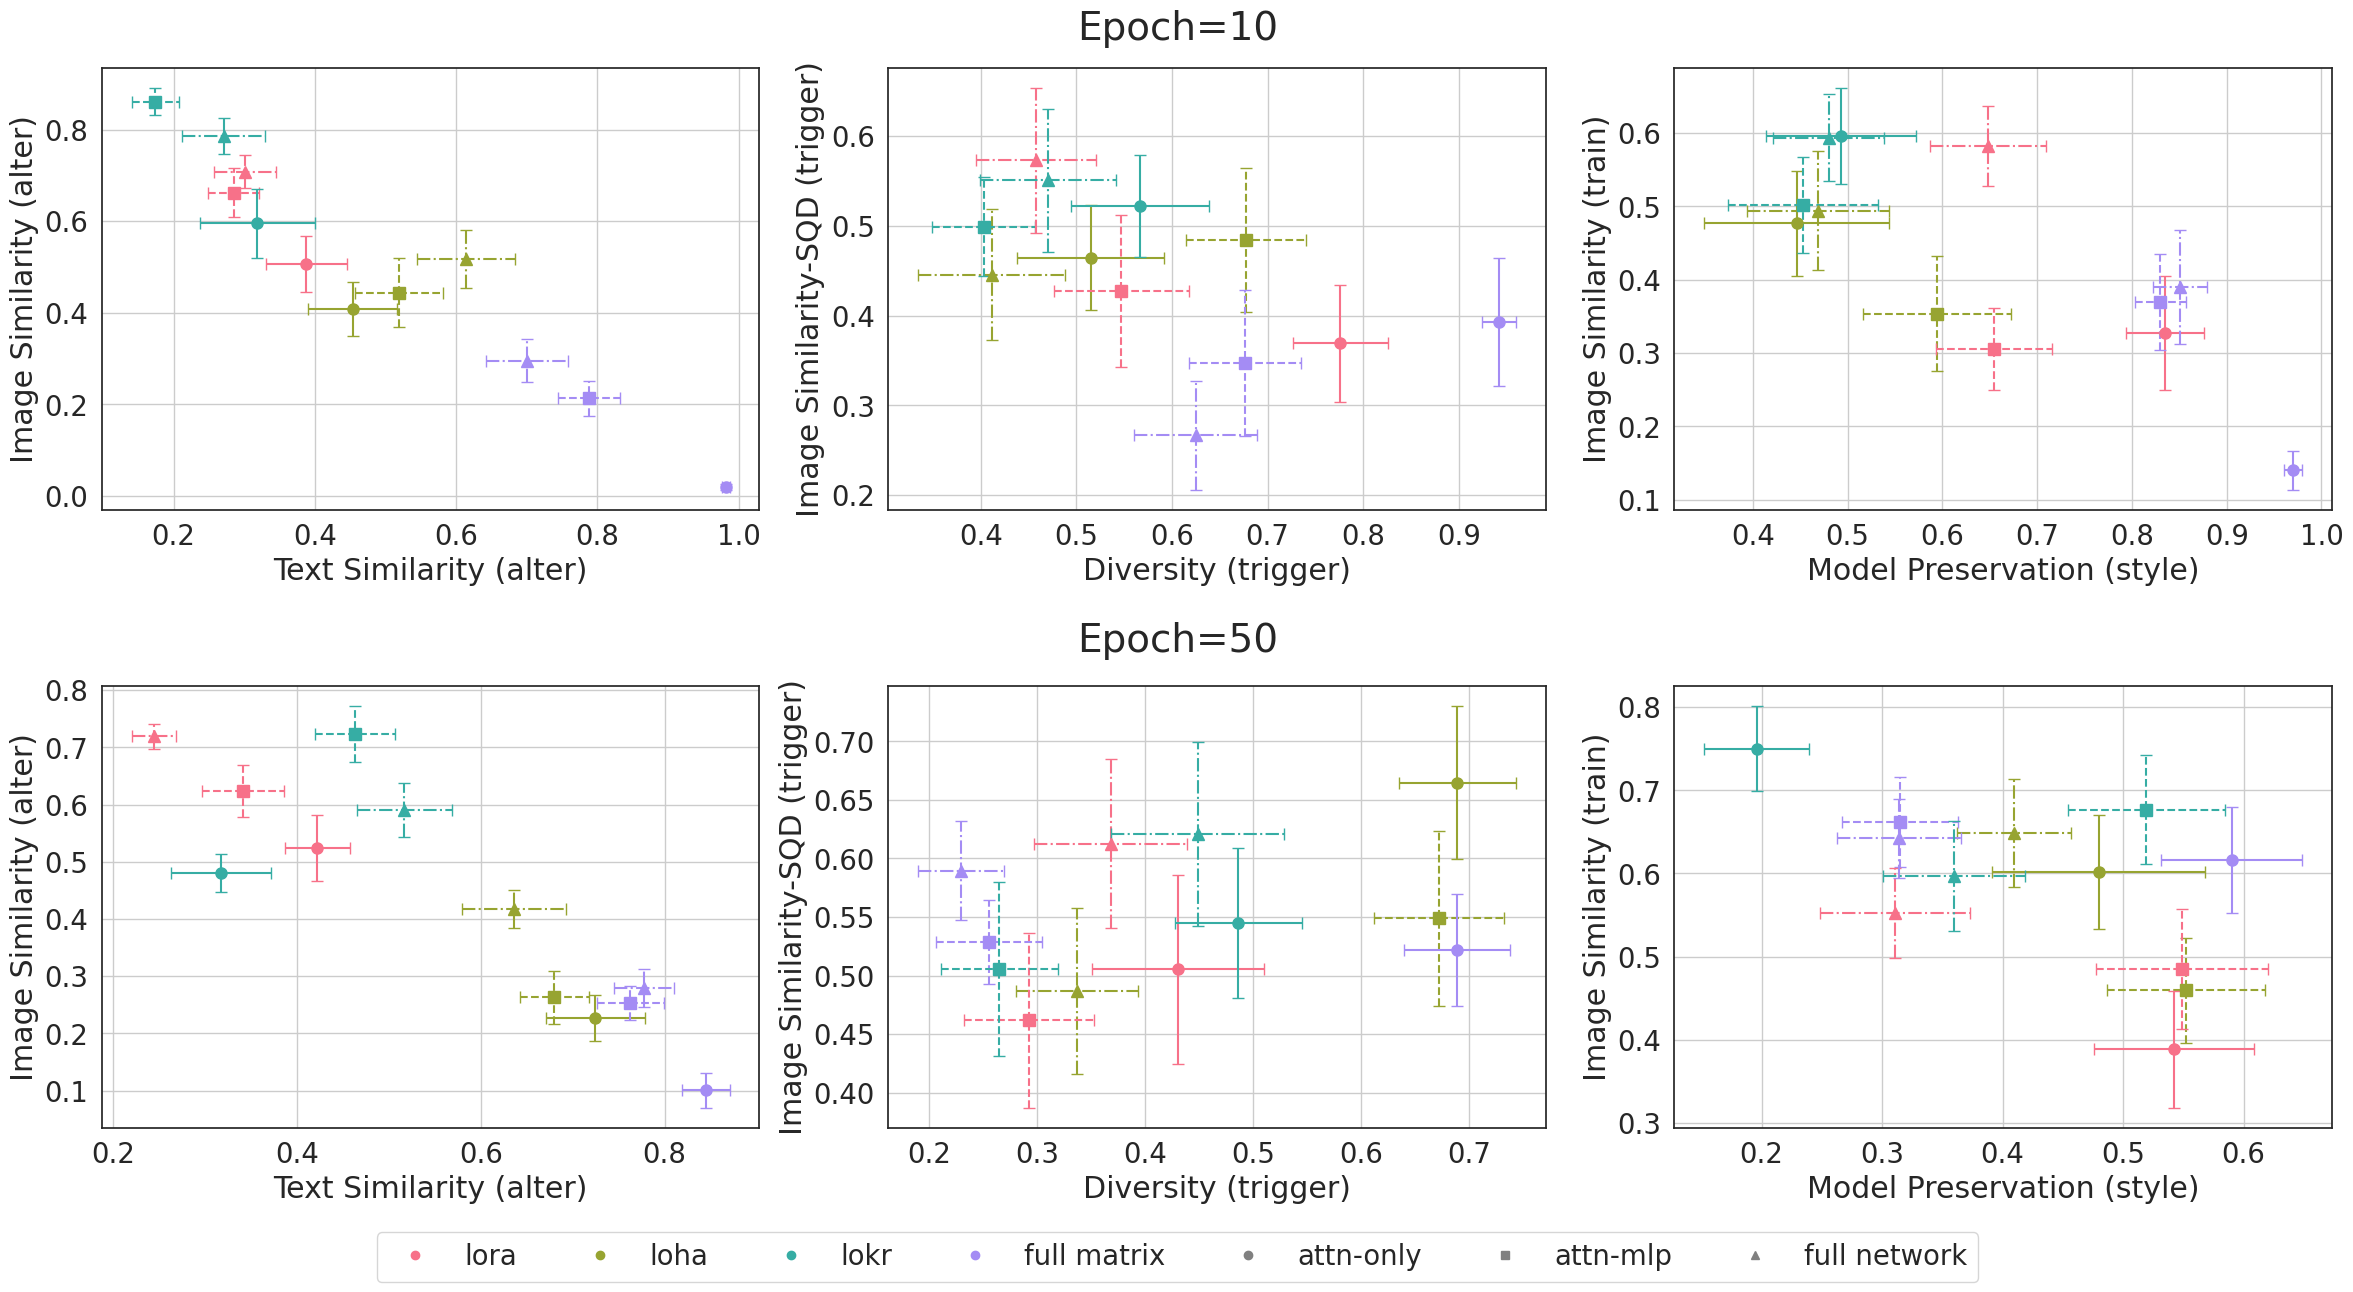

In [44]:
plt.figure(figsize=figsize_large)

for row, step in enumerate([10, 50]):

    # Add a subtitle to the top of each row of subplots
    plt.figtext(0.5,
                0.99 - 0.51 * row,
                f'Epoch={step}',
                ha='center',
                va='bottom',
                fontsize=28)

    for i, metric_pair in enumerate(metrics_to_plot):
        plt.subplot(2, 3, row * 3 + i + 1)
        legend_handles = plot_metrics_xy(metrics_aggregated,
                                         metric_pair[0],
                                         metric_pair[1],
                                         color_by='Algo',
                                         shape_by='Preset',
                                         legend=False,
                                         step=step)

fig = plt.gcf()

fig.legend(handles=legend_handles,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.05),
           ncol=len(legend_handles))
plt.tight_layout()
# Adjust the height of the space between subplots
fig.subplots_adjust(hspace=0.4)

for ext in ['.png', '.pdf']:
    plt.savefig(os.path.join(save_dir, f'preset_{category}_xyplot' + ext),
                bbox_inches='tight',
                pad_inches=0.2)

## Capacity

In [45]:
metrics_aggregated = filter_config_and_aggregate(metrics_processed,
                                                 ['Dim', 'Factor'],
                                                 extra_conodition)
metrics_aggregated = transform_attributes(metrics_aggregated,
                                          multiindex=True,
                                          drop=False)
condition = (metrics_aggregated['Alpha']
             == 1) & (metrics_aggregated['Algo'].isin(['lora', 'loha']))
metrics_aggregated.loc[condition, 'Capacity'] = 4
metrics_aggregated = metrics_aggregated[metrics_aggregated['Algo'] != 'full']
shape_mapping = {
    1: 'factor=12',
    2: 'dim=4/8 | factor=8',
    3: 'dim=16/32 | factor=4',
    4: 'dim=16/32, alpha=1'
}

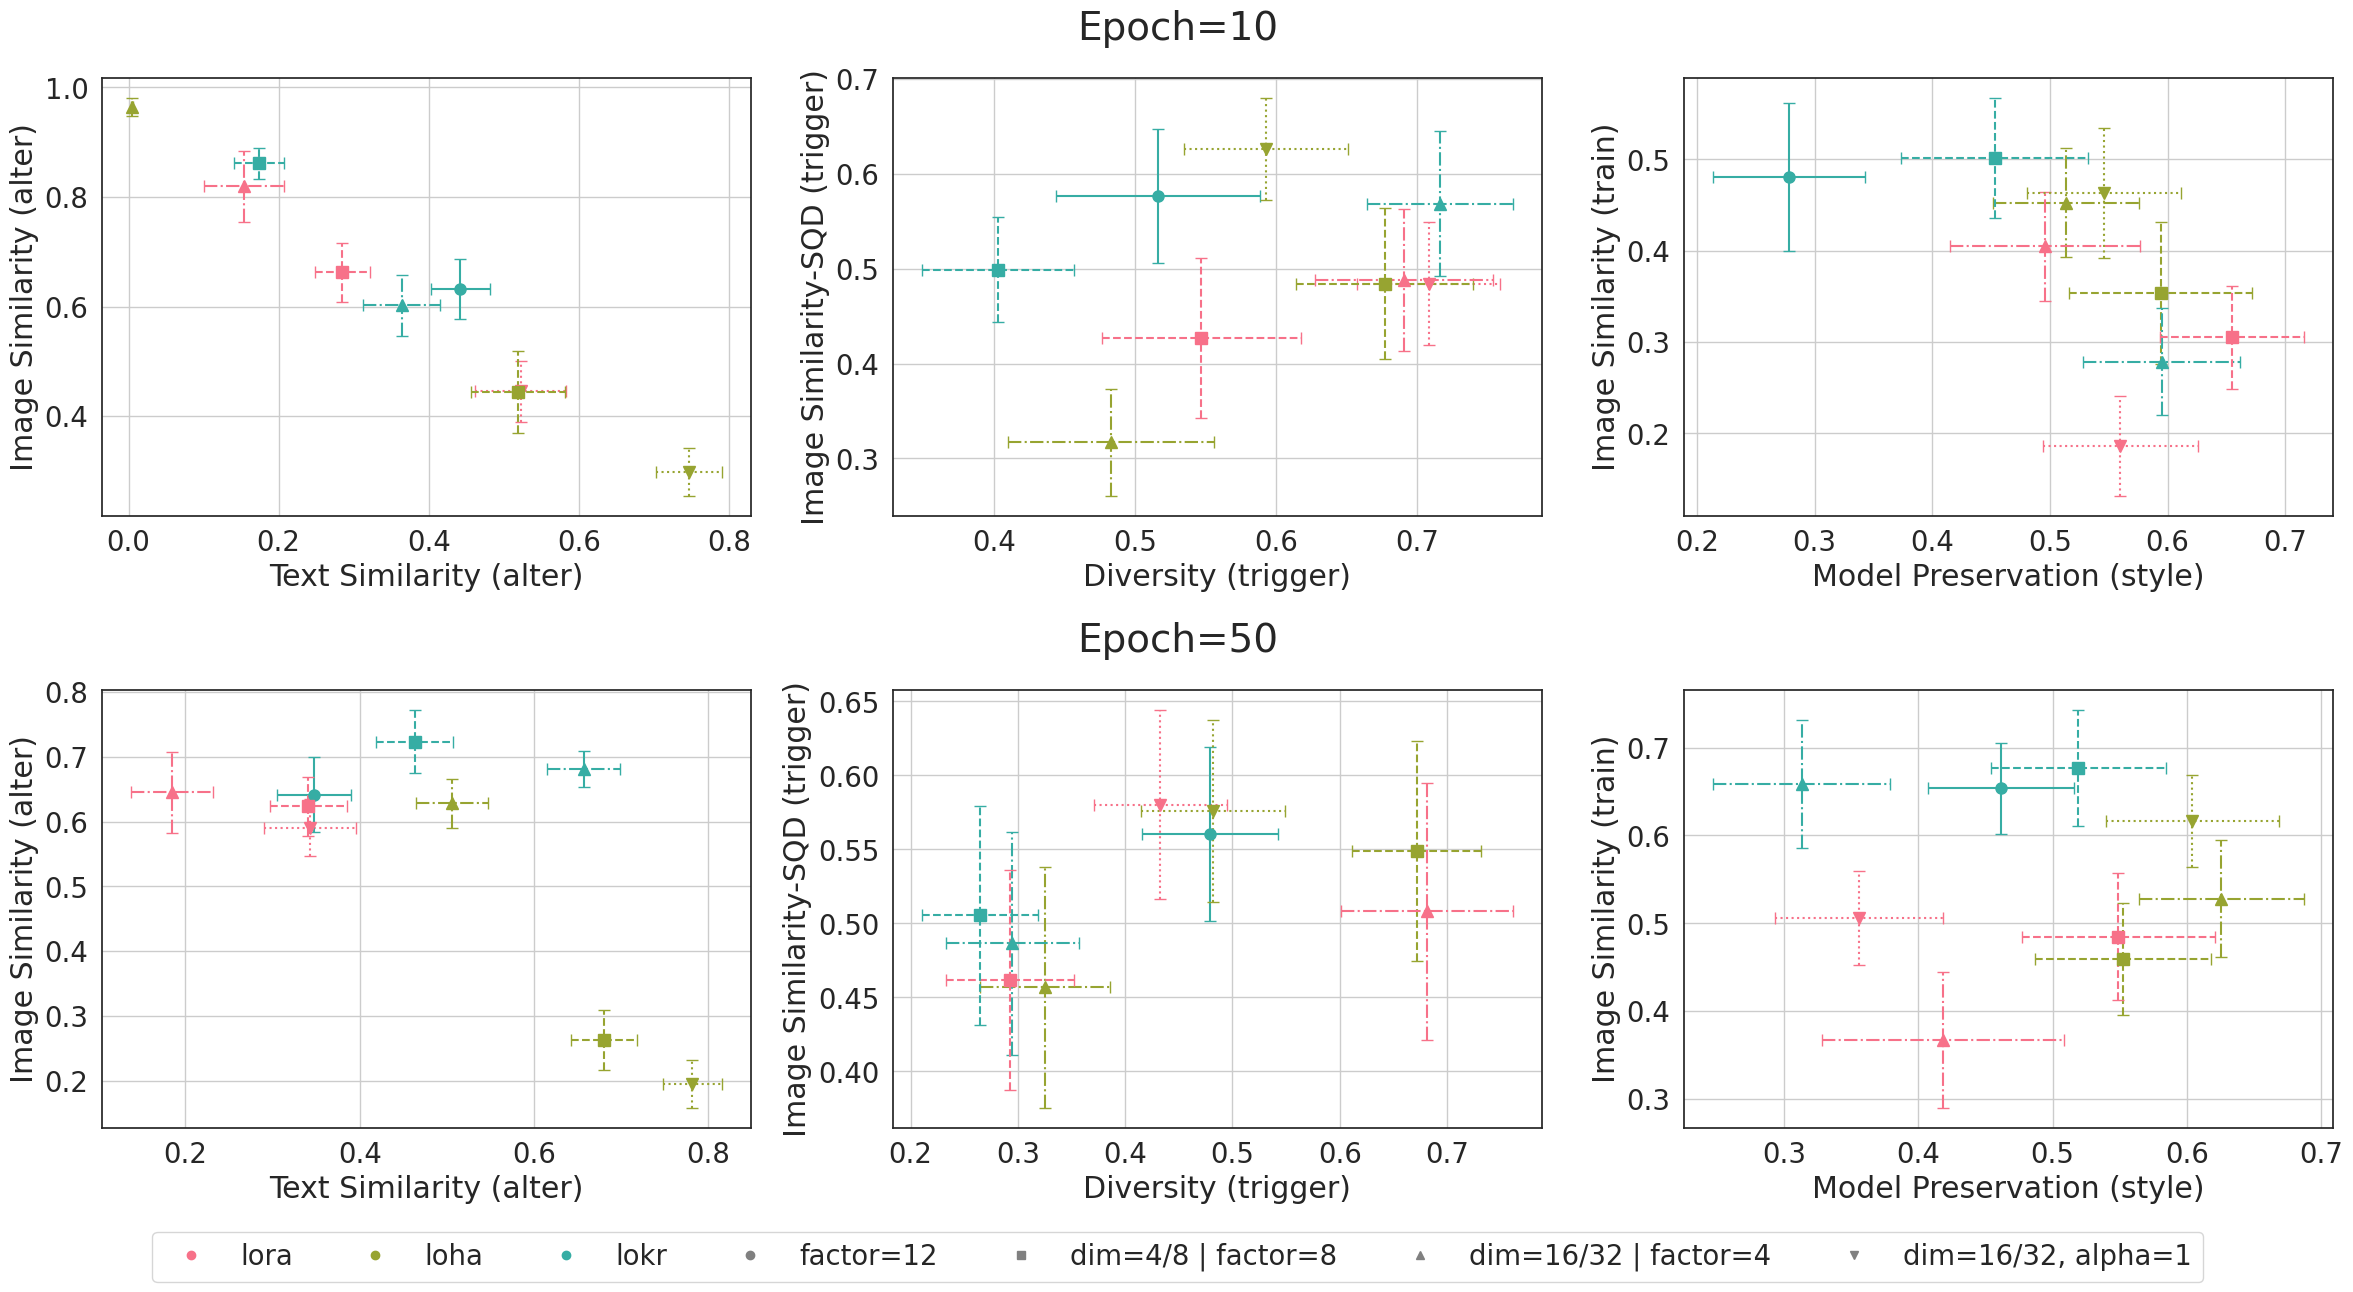

In [46]:
plt.figure(figsize=figsize_large)

for row, step in enumerate([10, 50]):
    
    # Add a subtitle to the top of each row of subplots
    plt.figtext(0.5,
                0.99 - 0.51 * row,
                f'Epoch={step}',
                ha='center',
                va='bottom',
                fontsize=28)

    for i, metric_pair in enumerate(metrics_to_plot):
        plt.subplot(2, 3, row * 3 + i + 1)
        legend_handles = plot_metrics_xy(metrics_aggregated,
                                         metric_pair[0],
                                         metric_pair[1],
                                         color_by='Algo',
                                         shape_by='Capacity',
                                         use_full=False,
                                         shape_mapping=shape_mapping,
                                         legend=False,
                                         step=step)
fig = plt.gcf()
fig.legend(handles=legend_handles,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.05),
           ncol=len(legend_handles))
           #columnspacing=0.8)  # adjust this value as needed
plt.tight_layout()
fig.subplots_adjust(hspace=0.4)

for ext in ['.png', '.pdf']:
    plt.savefig(os.path.join(save_dir, f'capacity_{category}_xyplot' + ext),
                bbox_inches='tight',
                pad_inches=0.2)

## Lr

In [47]:
metrics_aggregated = filter_config_and_aggregate(metrics_processed, ['Lr'],
                                                 extra_conodition)
metrics_aggregated = transform_attributes(metrics_aggregated,
                                          multiindex=True,
                                          drop=False)
shape_mapping = {
    1: 'lr=1e-4/5e-7',
    2: 'lr=5e-4/1e-6',
    3: 'lr=1e-3/5e-6',
}

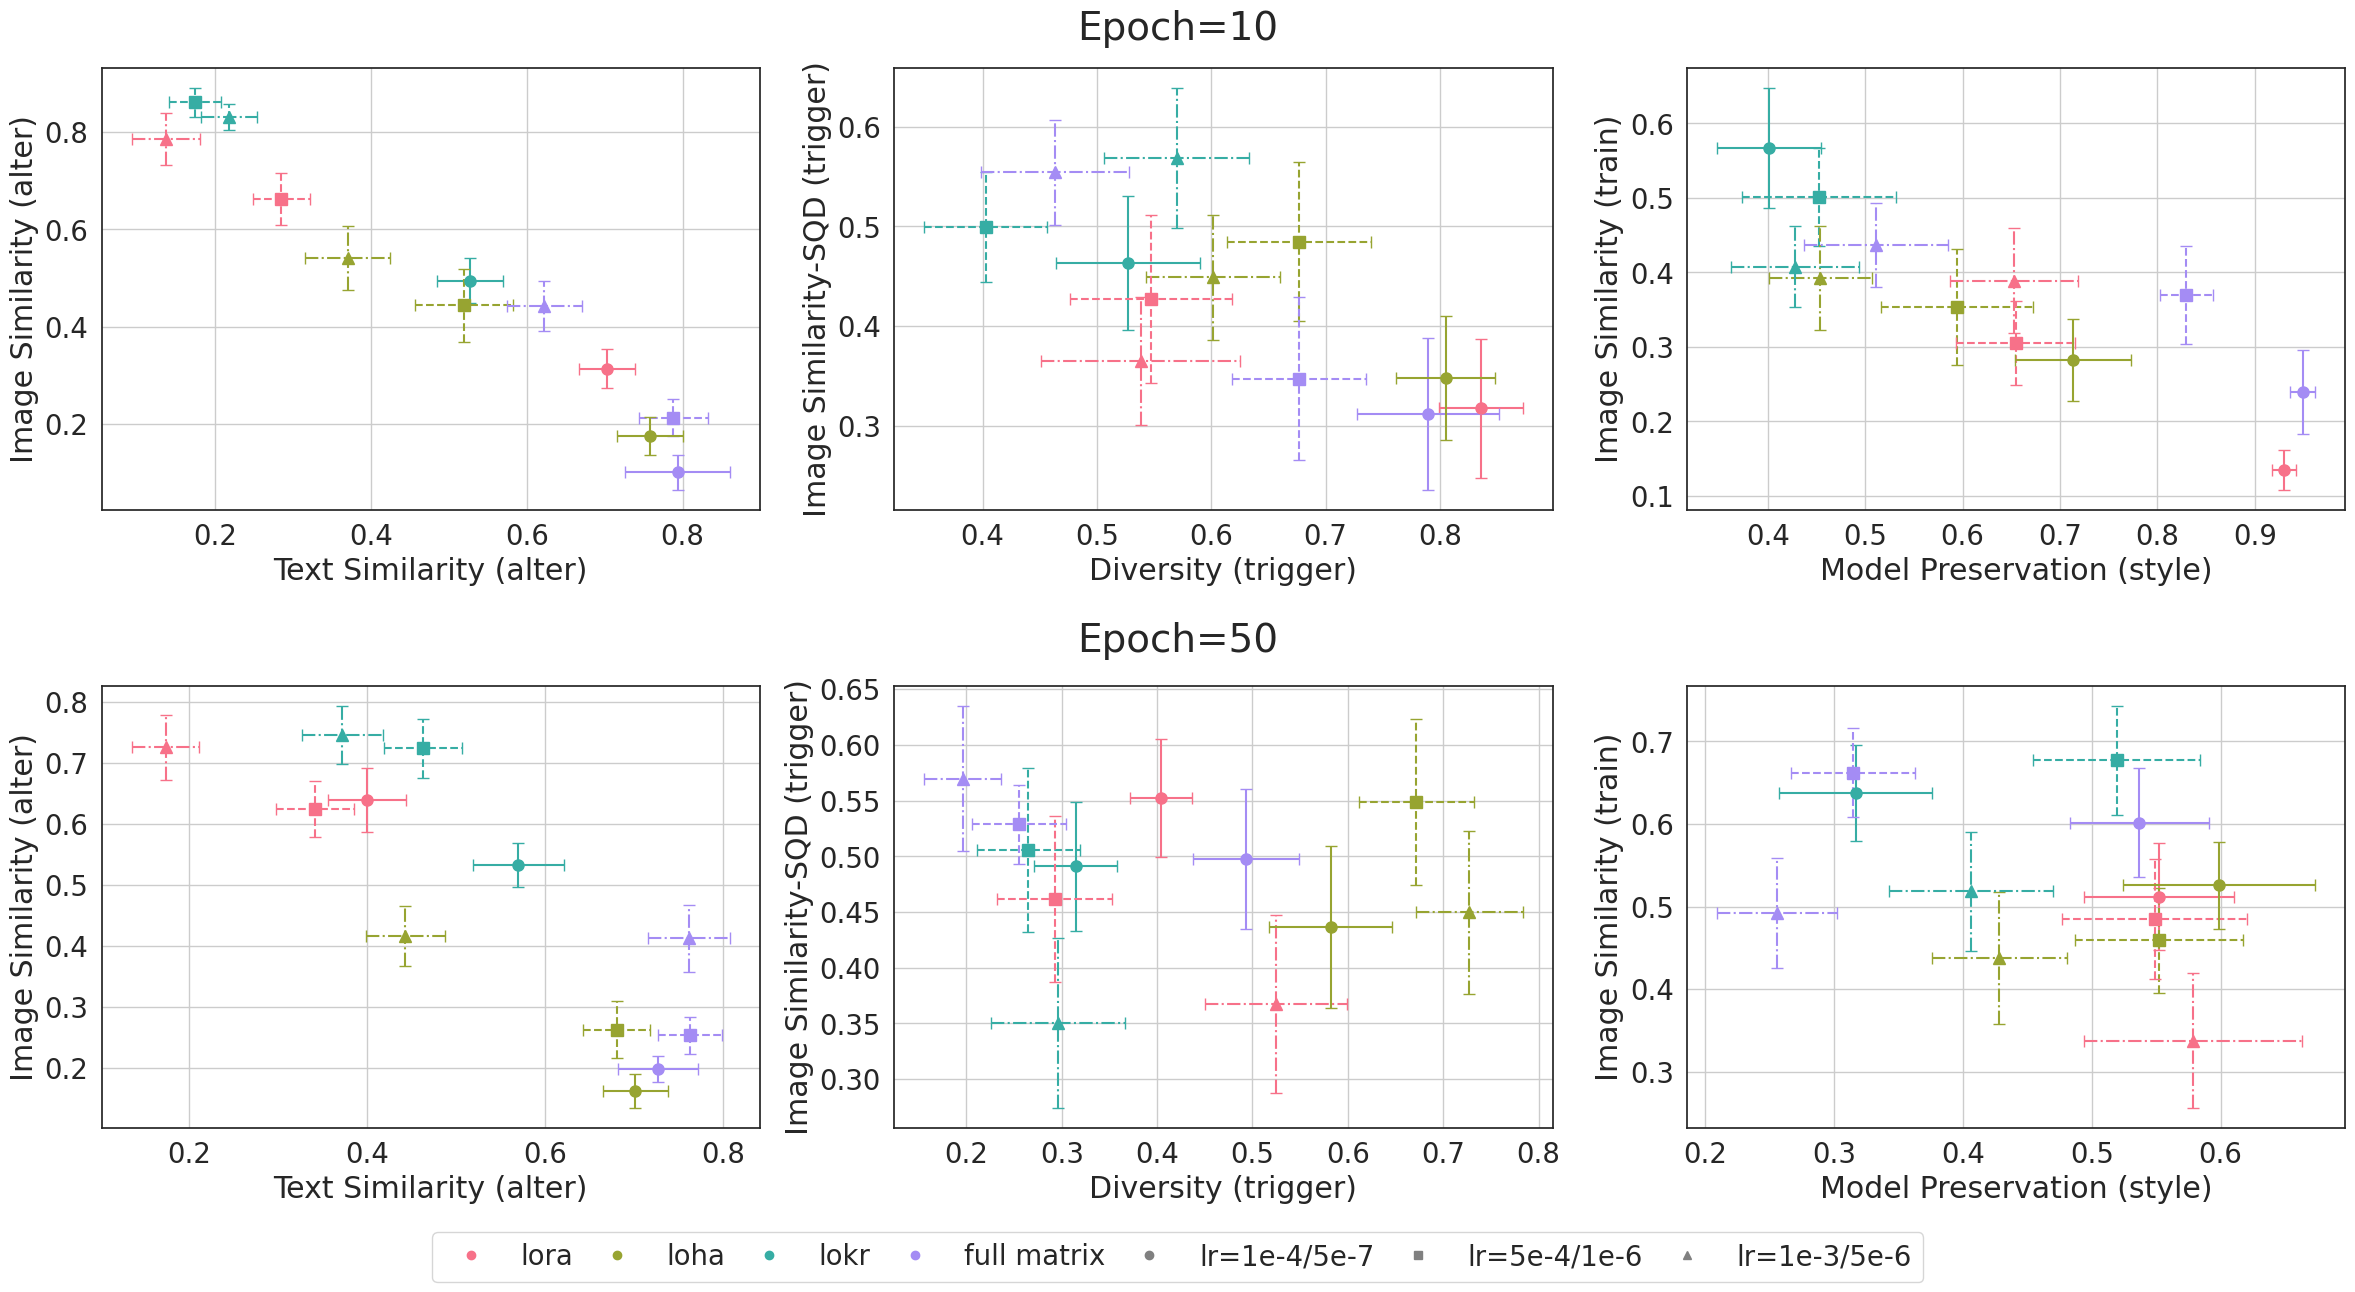

In [48]:
plt.figure(figsize=figsize_large)

for row, step in enumerate([10, 50]):
    
    # Add a subtitle to the top of each row of subplots
    plt.figtext(0.5,
                0.99 - 0.51 * row,
                f'Epoch={step}',
                ha='center',
                va='bottom',
                fontsize=28)

    for i, metric_pair in enumerate(metrics_to_plot):
        plt.subplot(2, 3, row * 3 + i + 1)
        legend_handles = plot_metrics_xy(metrics_aggregated,
                                         metric_pair[0],
                                         metric_pair[1],
                                         color_by='Algo',
                                         shape_by='Lr Level',
                                         shape_mapping=shape_mapping,
                                         legend=False,
                                         step=step)
fig = plt.gcf()
fig.legend(handles=legend_handles,
           loc='lower center',
           bbox_to_anchor=(0.5, -0.05),
           ncol=len(legend_handles),
           columnspacing=0.6)  # adjust this value as needed
plt.tight_layout()
fig.subplots_adjust(hspace=0.4)

for ext in ['.png', '.pdf']:
    plt.savefig(os.path.join(save_dir, f'lr_{category}_xyplot' + ext),
                bbox_inches='tight',
                pad_inches=0.2)